# Load data

In [ ]:
import pandas as pd

df1 = pd.read_csv('/content/drive/MyDrive/AI Fin Fraud Detector/正式專案/爬蟲/scam_records_1.csv', delimiter=",")
df1 = df1["Content"]
# print(df1.head())

df2 = pd.read_csv('/content/drive/MyDrive/AI Fin Fraud Detector/正式專案/爬蟲/scam_records_2.csv', delimiter=",")
df2 = df2["Content"]
# print(df2.head())

df3 = pd.read_csv('/content/drive/MyDrive/AI Fin Fraud Detector/正式專案/爬蟲/scam_records_3.csv', delimiter=",")
df3 = df3["texts"]
# print(df3.head())

df4 = pd.read_csv('/content/drive/MyDrive/AI Fin Fraud Detector/正式專案/爬蟲/scam_records_4.csv', delimiter=",")
df4 = df4["content"]
# print(df4.head())

df5 = pd.read_csv('/content/drive/MyDrive/AI Fin Fraud Detector/正式專案/爬蟲/scam_records_5.csv', delimiter=",", encoding="ISO-8859-1")
df5 = df5.iloc[:, 0]
# print(df5.head())

# concatenate all dataset
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df = pd.DataFrame(df, columns=["Texts"])
df["ID"] = df.index
df = df.iloc[:, ::-1] # reverse the order of columns
print(df)

        ID                                              Texts
0        0  My favorite is the “Grandma I’m in trouble cal...
1        1  I might be a little biased, but as an Asana em...
2        2  I had the “I’m calling to fix your Windows” ca...
3        3  One time, I was hanging out at my grandmother’...
4        4  A young woman, perhaps in her early twenties b...
...    ...                                                ...
1033  1033  This is a notification from your bank's fraud ...
1034  1034  It's essential to install this security update...
1035  1035  For security reasons, we need you to verify yo...
1036  1036  There's been a breach involving your personal ...
1037  1037  We're transferring your funds to a secure wall...

[1038 rows x 2 columns]


# Create keyword dataset

## GPT-4 interpretation for "Money related" selection:
當程式碼遍歷每個關鍵字時，它使用 str.contains 方法來選擇包含該關鍵字的文本。接著，將這些包含關鍵字的文本所對應的 ID 儲存在結果表格中的一個欄位中。

對於第一個關鍵字（例如 "money"），程式碼將其對應的文本ID儲存在結果表格的第一列中。然後，程式碼檢查後續關鍵字（例如 "card"）的文本，如果這些文本的ID已經在結果表格的第一列中，則不會再次將該ID存儲到結果表格中。相反，它會將關鍵字（例如 "card"）儲存在結果表格的第一列中，表示這些 ID 同時包含 "money" 和 "card" 這兩個關鍵字。

如果某些文本的 ID 不在結果表格的第一列中，表示這些文本只包含目前正在處理的關鍵字，而不包含之前的關鍵字。在這種情況下，程式碼會將這些ID存儲到結果表格的第一列中，並將正在處理的關鍵字（例如 "card"）存儲到對應的列中，而其他列則填充為 "Not Exist"。

通過這樣的方式，結果表格中的每一列都對應於文本的 ID，而每一列中的每個欄位則對應於文本包含的關鍵字。這樣的設計使得我們可以追蹤每個文本的ID 以及文本包含的所有關鍵字，並且確保每個 ID 只儲存一次，以避免重複。







## GPT-4 interpretation for left columns selection:
排序在對每個文本進行檢查時進行。當檢查每個文本以確定它是否包含某一類別的關鍵字時，我們會按照您提供的順序（例如，對於個人資訊相關，以 account、address、information、details、id、email 的順序）來進行搜索。因此，如果文本同時包含多個關鍵字，我們會優先選擇列表中排在前面的關鍵字，並將其標記為文本的相應類別。這樣，即使文本包含多個關鍵字，我們也可以確保按照指定的順序對其進行分類。

In [ ]:
import pandas as pd
import numpy as np

# eliminate texts with NaN
df = df.dropna()
df = df.reset_index(drop=True)

# Initialize the result table
result = pd.DataFrame(columns=["ID", "Money related 1", "Money related 2", "Money related 3", "Money related 4",
                               "Money related 5", "Money related 6", "Money related 7", "Money related 8", "Money related 9",
                               "Personal information related", "Inducement words related", "Promotional content related", "Kinship related"])

# Money related keywords
money_keywords = ["money", "card", "credit", "bank", "insurance", "taxes", "bill", "dollars", "warrant"]

# Iterate through each keyword
for i, keyword in enumerate(money_keywords):
    # Find texts containing the keyword
    keyword_texts = df[df["Texts"].str.contains(keyword, case=False)] # ignore uppercase and lowercase

    # Initialize a list to store IDs for the current keyword
    keyword_ids = []

    # Iterate through each text containing the keyword
    for _, row in keyword_texts.iterrows():
        # Check if the current keyword is the first keyword or if the previous keyword is in the text
        if i == 0 or any(prev_keyword in row["Texts"].lower() for prev_keyword in money_keywords[:i]):
            # Append the ID to the list of IDs for the current keyword
            keyword_ids.append(row["ID"])
            # Update the corresponding column in the result table
            result.loc[result["ID"].isin(keyword_ids), f"Money related {i+1}"] = keyword

    # Store new IDs and keywords in the result table
    new_ids = list(set(keyword_texts["ID"]) - set(result["ID"]))
    new_data = pd.DataFrame({"ID": new_ids, f"Money related {i+1}": keyword})
    result = pd.concat([result, new_data], ignore_index=True)

# Fill missing values with 0
result = result.fillna(0)

# Personal information related keywords
personal_keywords = ["account", "address", "information", "details", "id", "email"]

# Inducement words related keywords
inducement_keywords = ["security", "problem", "support", "police", "virus", "accident", "irs", "message", "help", "arrest", "government", "device", "records", "access"]

# Promotional content related keywords
promotional_keywords = ["service", "internet", "system", "telemarketer", "course", "offer", "site", "sales", "gift", "order", "program", "activity", "software", "subscription", "customer"]

# Kinship related keywords
kinship_keywords = ["son", "husband", "wife", "mother", "dad", "children", "parents"]

# Iterate through each ID
for idx, row in result.iterrows():
    # Check for personal information related keywords
    for keyword in personal_keywords:
        if keyword in df.loc[row["ID"], "Texts"].lower():
            result.at[idx, "Personal information related"] = keyword
            break

    # Check for inducement words related keywords
    for keyword in inducement_keywords:
        if keyword in df.loc[row["ID"], "Texts"].lower():
            result.at[idx, "Inducement words related"] = keyword
            break

    # Check for promotional content related keywords
    for keyword in promotional_keywords:
        if keyword in df.loc[row["ID"], "Texts"].lower():
            result.at[idx, "Promotional content related"] = keyword
            break

    # Check for kinship related keywords
    for keyword in kinship_keywords:
        if keyword in df.loc[row["ID"], "Texts"].lower():
            result.at[idx, "Kinship related"] = keyword
            break

In [ ]:
result = result.sort_values(by="ID")
result.head(30)

,ID,Money related 1,Money related 2,Money related 3,Money related 4,Money related 5,Money related 6,Money related 7,Money related 8,Money related 9,Personal information related,Inducement words related,Promotional content related,Kinship related
0,3,money,0,0,0,0,0,0,0,0,id,help,0,mother
88,5,0,card,credit,0,0,0,0,0,0,address,irs,0,0
224,7,0,0,0,0,0,0,0,0,warrant,0,support,0,0
89,9,0,card,credit,0,0,0,0,0,0,account,0,service,husband
187,12,0,0,0,0,0,taxes,0,0,0,id,police,0,0
4,14,money,card,0,0,0,0,0,0,0,address,0,0,0
178,16,0,0,0,0,insurance,0,bill,0,0,0,records,offer,0
97,19,0,card,credit,0,0,0,0,0,0,id,0,0,0
8,20,money,0,0,bank,0,0,0,0,0,account,0,software,0
10,22,money,0,0,0,0,0,0,0,0,id,security,service,0


# Create complete data frame for generating

In [ ]:
result["Label"] = len(result) * [1]
result.head(30)

,ID,Money related 1,Money related 2,Money related 3,Money related 4,Money related 5,Money related 6,Money related 7,Money related 8,Money related 9,Personal information related,Inducement words related,Promotional content related,Kinship related,Label
0,3,money,0,0,0,0,0,0,0,0,id,help,0,mother,1
88,5,0,card,credit,0,0,0,0,0,0,address,irs,0,0,1
224,7,0,0,0,0,0,0,0,0,warrant,0,support,0,0,1
89,9,0,card,credit,0,0,0,0,0,0,account,0,service,husband,1
187,12,0,0,0,0,0,taxes,0,0,0,id,police,0,0,1
4,14,money,card,0,0,0,0,0,0,0,address,0,0,0,1
178,16,0,0,0,0,insurance,0,bill,0,0,0,records,offer,0,1
97,19,0,card,credit,0,0,0,0,0,0,id,0,0,0,1
8,20,money,0,0,bank,0,0,0,0,0,account,0,software,0,1
10,22,money,0,0,0,0,0,0,0,0,id,security,service,0,1


# NA values handling - last 4 columns

## Visualize the distribution of each columns' keywords

<ipython-input-193-e7a9e6e26c5c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


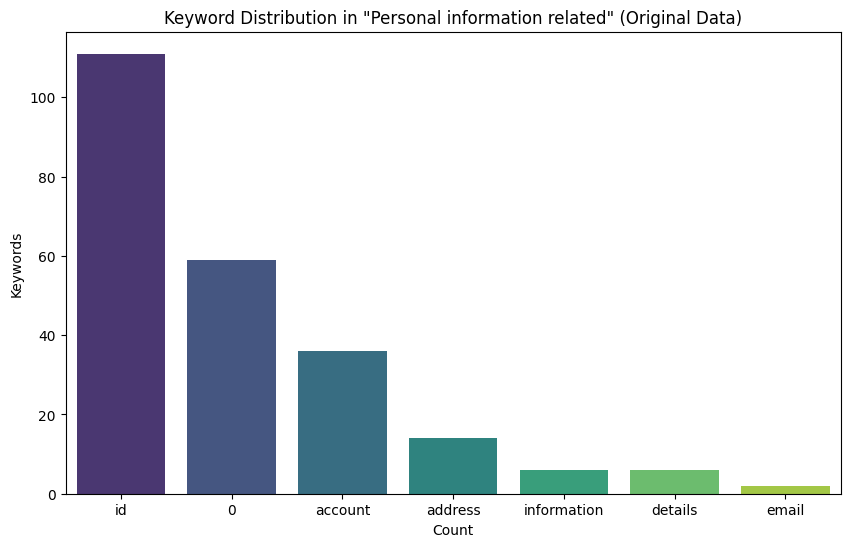

<ipython-input-193-e7a9e6e26c5c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


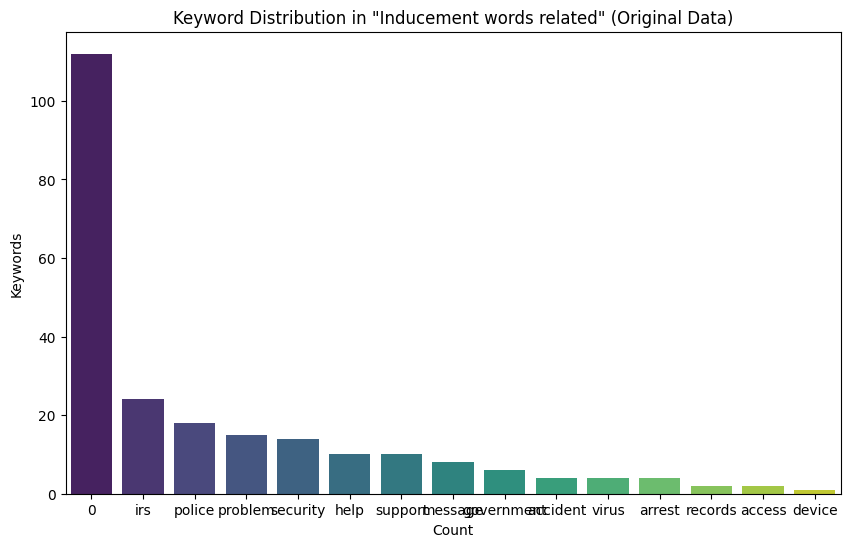

<ipython-input-193-e7a9e6e26c5c>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


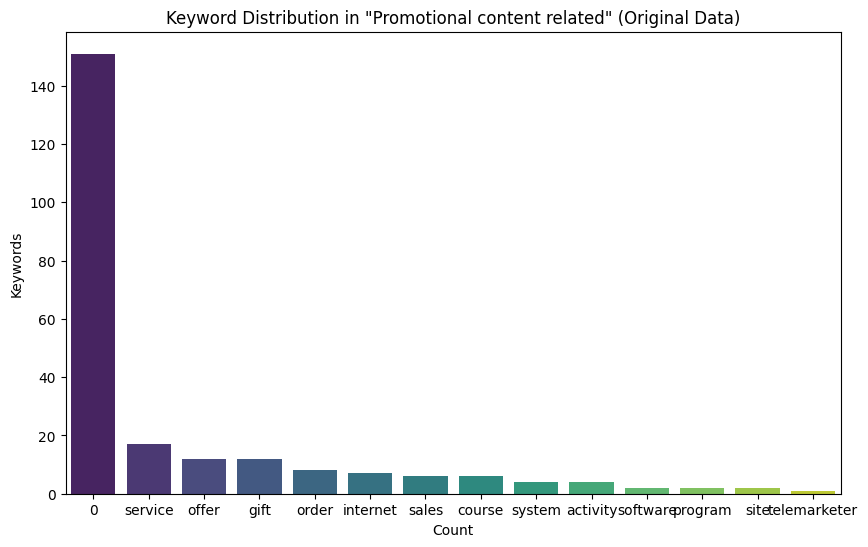

<ipython-input-193-e7a9e6e26c5c>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


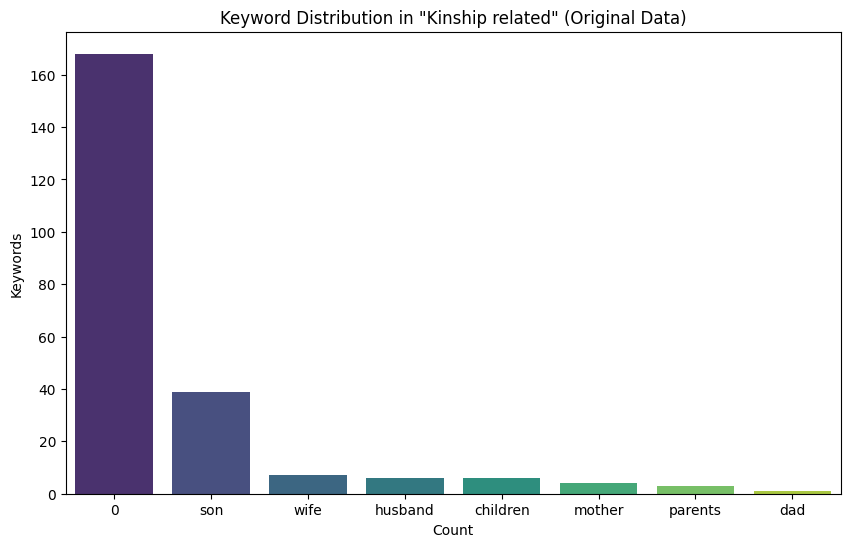

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count keywords in the original data including NaN values
original_keyword_counts = result["Personal information related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Personal information related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Inducement words related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Inducement words related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Promotional content related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Promotional content related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Kinship related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Kinship related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

## Count the number of 0(NA) in the last four columns

In [ ]:
latterColumns = result.loc[:, ["Personal information related", "Inducement words related", "Promotional content related", "Kinship related"]]
print(latterColumns[latterColumns == 0].count(axis=0))

# Calculate the proportion of missing values ​​in all data
for col in latterColumns.columns:
    print(f'{col}: {latterColumns[col].value_counts()[0]} / {latterColumns[col].count()}')

Personal information related     59
Inducement words related        112
Promotional content related     151
Kinship related                 168
dtype: int64
Personal information related: 59 / 234
Inducement words related: 112 / 234
Promotional content related: 151 / 234
Kinship related: 168 / 234


## Count the number of rows in the result in which the four fields aren't 0(NA)

In [ ]:
latterColumns[
    (latterColumns["Personal information related"] != 0)
    & (latterColumns["Inducement words related"] != 0)
    & (latterColumns["Promotional content related"] != 0)
    & (latterColumns["Kinship related"] != 0)
    ].count()

Personal information related    5
Inducement words related        5
Promotional content related     5
Kinship related                 5
dtype: int64

## Use mice imputation to fill NA values

The order of filling missing values:

1.   Personal information related
2.   Inducement words related
3.   Promotional content related
4.   Kinship related

Missing value imputation way:



In [ ]:
import torch.utils.data.dataset as dataset

class LatterDataset(dataset.Dataset):
    def __init__(self, X: pd.DataFrame, Y: pd.Series):

        # Filter out rows where Y is 0 (no answer criteria)
        # valueCount = {colName: len(X[colName].unique()) for colName in X.columns}
        haveAnsCritiria = Y != 0
        X = X[haveAnsCritiria]
        Y = Y[haveAnsCritiria]

        # Perform one-hot encoding on categorical columns and concatenate them
        self.X = pd.concat(
            (
                pd.Series(oneHotCol, name=f"{origColName}_{oneHotColName}")
                for origColName, origCol in X.items()
                for oneHotColName, oneHotCol in pd.get_dummies(origCol)
                    .drop(labels=(0), axis=1, errors="ignore")
                    .items()
            ),
            axis=1,
        )

        # Create a mapping from label to index
        self.YMapping = {label: idx for idx, label in enumerate(Y.unique())}
        self.inverse_YMapping = None

        # Map labels to their corresponding indices
        self.Y = Y.map(self.YMapping)
        # self.Y = pd.get_dummies(Y)

    def restoreX(self, index: int):

        # Restore the original column name from an index
        try:
            return self.X.columns[index]
        except KeyError:
            return "unknown"

    def restoreY(self, index: int):

        # Restore the original label from an index
        if not self.inverse_YMapping:
            self.inverse_YMapping = {v: k for k, v in self.YMapping.items()}
        try:
            return self.inverse_YMapping[index]
        except KeyError:
            return "unknown"

    def transformX(self, columnName: str, value: str):

        # Transform a column name and value to its corresponding index
        try:
            # KeyError might appear
            return self.X.columns.get_loc(f"{columnName}_{value}")
        except KeyError:
            return -1

    def transformY(self, value: str):

        # Transform a label to its corresponding index
        try:
            # KeyError might appear
            return self.YMapping[value]
        except KeyError:
            return -1

    def __len__(self):

        # Return the length of the dataset
        return len(self.X)

    def __getitem__(self, index):

        # Get the X and Y values at a specific index
        return self.X.iloc[index].to_numpy().astype(np.float32), self.Y.iloc[index]

In [ ]:
batch_size = 64
epochs = 7

In [ ]:
import torch
from torch import nn

class Predictor(nn.Module):

    # define frameworks of each neural layer
    def __init__(self, input_size, output_size):
        super().__init__()

        # define neural layers
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    # define forward propagation function to connect layers(including activation function)
    def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs, batch_size, dataloaders, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1000000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 1000000.0  # Large arbitrary number

    print("Training started")
    for epoch in range(num_epochs):
        dataset_sizes = {
            "train": len(dataloaders["train"]),
            "val": len(dataloaders["val"]),
        }

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iteration loop
            running_loss = 0.0
            running_corrects = 0
            n_batches = dataset_sizes[phase]
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)  # shape: (batch_size,)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)  # shape: (batch_size, num_classes)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print('\rPhase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='', flush=True)
                it += 1

            if phase == "train":
                scheduler.step()  # Update the learning rate

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase] / batch_size
            epoch_acc = running_corrects / dataset_sizes[phase] / batch_size
            print('\rPhase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'test ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

            # Check if this is the best model wrt previous epochs
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'train' and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == 'train' and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [ ]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader as dataloader
from typing import List


def genDataloader(xColNames, yColName):

    # Extract feature columns and label column from the result DataFrame
    X = result[xColNames]
    Y = result[yColName]

    # Split the dataset into training and validation sets
    dataset_train, dataset_val = torch.utils.data.random_split(
        LatterDataset(X, Y),
        [0.8, 0.2],
    )

    # Create DataLoader objects for training and validation datasets
    data = {
        "train": dataloader.DataLoader(
            dataset_train,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
        ),
        "val": dataloader.DataLoader(
            dataset_val,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
        ),
    }
    return data

def genAndTrainModel(dataloaders) -> Predictor:
    model = Predictor(dataloaders["train"].dataset.dataset.X.shape[1], len(dataloaders["train"].dataset.dataset.YMapping))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model = train_model(model, criterion, optimizer, exp_lr_scheduler, epochs, batch_size, dataloaders, device)
    return model

def impute(model: Predictor, dataloaders: dict, xColNames: List[str], yColName: str, device: torch.device):

    # Extract feature columns and label column from the result DataFrame
    X = result[xColNames]
    Y = result[yColName]

    # Identify indices of missing values in the label column
    missingValueIndices = Y[(Y == 0) | (Y == "0")].index
    X = pd.concat(
        (
            pd.Series(oneHotCol, name=f"{origColName}_{oneHotColName}")
            for origColName, origCol in X.items()
            for oneHotColName, oneHotCol in pd.get_dummies(origCol)
                .drop(labels=(0), axis=1, errors="ignore")
                .items()
        ),
        axis=1,
    )

    # Ensure the one-hot encoded features match the training set columns
    X = X[dataloaders["train"].dataset.dataset.X.columns]

    # Map the labels to their corresponding indices
    Y = Y.map(dataloaders["train"].dataset.dataset.YMapping)

    # Prepare the input features for missing value indices
    inputs = X.loc[missingValueIndices].to_numpy().astype(np.float32)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    inputs = inputs.to(device)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)

    # Convert model outputs to predicted classes
    _, preds = torch.max(outputs, 1)

    # Restore the predicted labels to their original form
    predsRestored = np.vectorize(dataloaders["train"].dataset.dataset.restoreY)(preds.cpu())

    # Update the original DataFrame with the imputed values
    result.loc[missingValueIndices, yColName] = predsRestored

In [ ]:
xColumnNames = ["Personal information related", "Inducement words related", "Promotional content related", "Kinship related"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for _ in range(len(xColumnNames)):

    # Pop the first column to use as the label column
    yColumnName = xColumnNames.pop(0)

    # Generate data loaders for training and validation
    data = genDataloader(xColumnNames, yColumnName)

    # Generate and train the model
    model = genAndTrainModel(data)

    # Impute missing values in the label column using the trained model
    impute(model, data, xColumnNames, yColumnName, device)

    # Append the label column back to the feature columns list
    xColumnNames.append(yColumnName)

Training started
Phase: train Epoch: 1/7 Loss: 1.3332 Acc: 0.0260             
Phase: test  Epoch: 1/7 Loss: 0.9882 Acc: 0.0625             
Phase: train Epoch: 2/7 Loss: 1.3025 Acc: 0.0990             
Phase: test  Epoch: 2/7 Loss: 0.9688 Acc: 0.0938             
Phase: train Epoch: 3/7 Loss: 1.2724 Acc: 0.1979             
Phase: test  Epoch: 3/7 Loss: 0.9488 Acc: 0.1719             
Phase: train Epoch: 4/7 Loss: 1.2397 Acc: 0.3333             
Phase: test  Epoch: 4/7 Loss: 0.9272 Acc: 0.2500             
Phase: train Epoch: 5/7 Loss: 1.2038 Acc: 0.4167             
Phase: test  Epoch: 5/7 Loss: 0.9032 Acc: 0.3125             
Phase: train Epoch: 6/7 Loss: 1.1627 Acc: 0.4844             
Phase: test  Epoch: 6/7 Loss: 0.8767 Acc: 0.3281             
Phase: train Epoch: 7/7 Loss: 1.1172 Acc: 0.4688             
Phase: test  Epoch: 7/7 Loss: 0.8472 Acc: 0.3281             
Training completed in 0m 0s
Best test loss: 0.8472 | Best test accuracy: 0.3281
Training started
Phase: train Epoch

## Visualize the distribution after imputation to see the changes

<ipython-input-202-679447bb4340>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


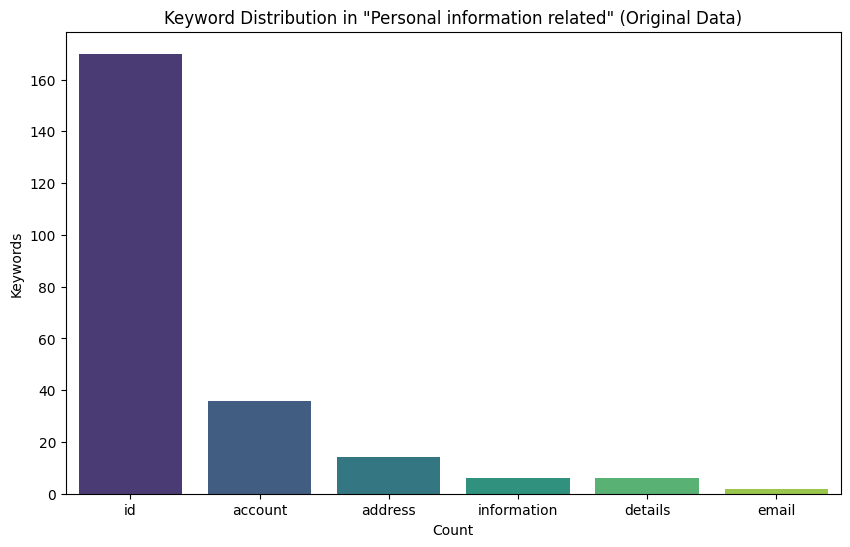

<ipython-input-202-679447bb4340>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


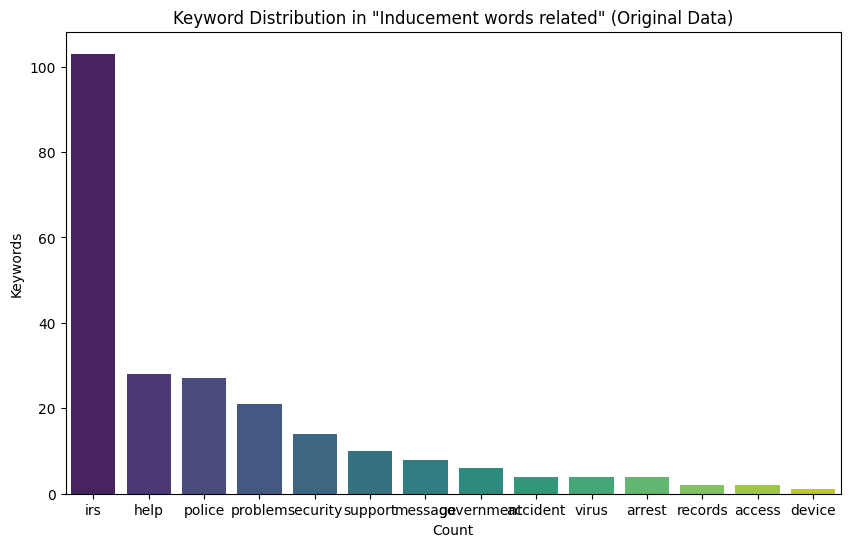

<ipython-input-202-679447bb4340>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


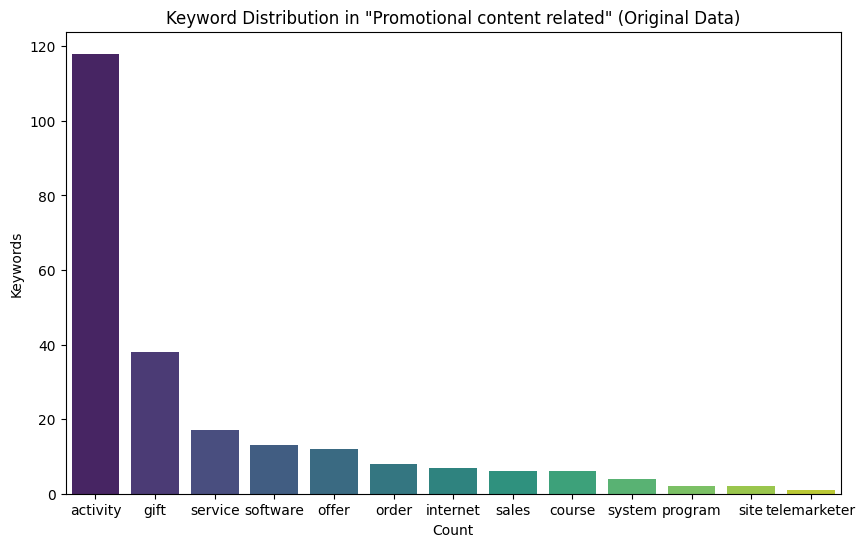

<ipython-input-202-679447bb4340>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


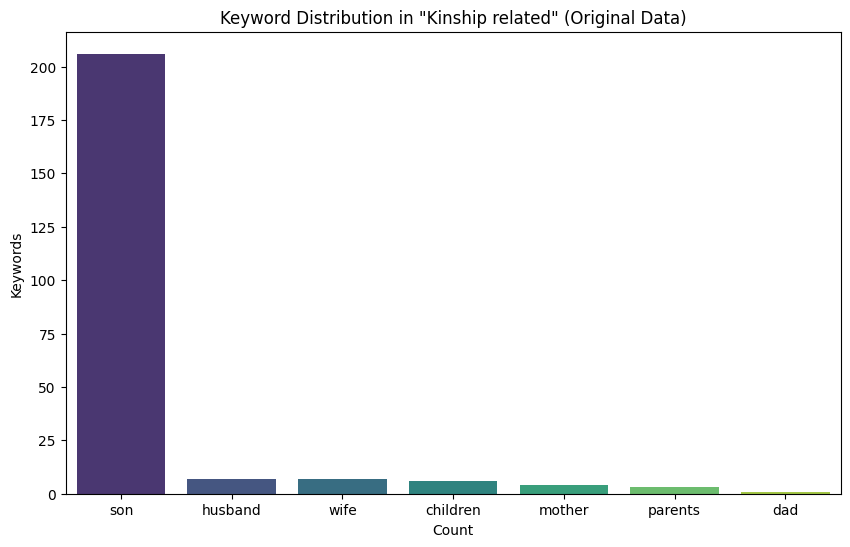

In [ ]:
# Count keywords in the original data including NaN values
original_keyword_counts = result["Personal information related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Personal information related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Inducement words related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Inducement words related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Promotional content related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Promotional content related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Count keywords in the original data including NaN values
original_keyword_counts = result["Kinship related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Kinship related" (Original Data)')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

## Check new data frame

In [ ]:
result.head(30)

,ID,Money related 1,Money related 2,Money related 3,Money related 4,Money related 5,Money related 6,Money related 7,Money related 8,Money related 9,Personal information related,Inducement words related,Promotional content related,Kinship related,Label
0,3,money,0,0,0,0,0,0,0,0,id,help,activity,mother,1
88,5,0,card,credit,0,0,0,0,0,0,address,irs,activity,son,1
224,7,0,0,0,0,0,0,0,0,warrant,id,support,activity,son,1
89,9,0,card,credit,0,0,0,0,0,0,account,problem,service,husband,1
187,12,0,0,0,0,0,taxes,0,0,0,id,police,gift,son,1
4,14,money,card,0,0,0,0,0,0,0,address,irs,activity,son,1
178,16,0,0,0,0,insurance,0,bill,0,0,id,records,offer,son,1
97,19,0,card,credit,0,0,0,0,0,0,id,irs,activity,son,1
8,20,money,0,0,bank,0,0,0,0,0,account,help,software,son,1
10,22,money,0,0,0,0,0,0,0,0,id,security,service,son,1


# Money related columns transformation

## Calculate the maximum number of appearing times of non-zero values in each piece of data

In [ ]:
money_related_df = result.iloc[:, 1:10]
non_zero_counts = money_related_df.apply(lambda row: (row != 0).sum(), axis=1)
print(non_zero_counts.value_counts())

1    157
2     60
3     14
4      3
Name: count, dtype: int64


## Get result rows which non_zero_counts == 1

In [ ]:
indices_with_one_non_zero = non_zero_counts[non_zero_counts == 1].index
result = result.loc[indices_with_one_non_zero]
result.head(30)

,ID,Money related 1,Money related 2,Money related 3,Money related 4,Money related 5,Money related 6,Money related 7,Money related 8,Money related 9,Personal information related,Inducement words related,Promotional content related,Kinship related,Label
0,3,money,0,0,0,0,0,0,0,0,id,help,activity,mother,1
224,7,0,0,0,0,0,0,0,0,warrant,id,support,activity,son,1
187,12,0,0,0,0,0,taxes,0,0,0,id,police,gift,son,1
10,22,money,0,0,0,0,0,0,0,0,id,security,service,son,1
183,23,0,0,0,0,insurance,0,0,0,0,id,irs,activity,son,1
14,31,money,0,0,0,0,0,0,0,0,id,irs,activity,son,1
221,34,0,0,0,0,0,0,0,0,warrant,id,support,activity,son,1
106,36,0,card,0,0,0,0,0,0,0,address,irs,activity,son,1
225,40,0,0,0,0,0,0,0,0,warrant,id,police,gift,son,1
216,41,0,0,0,0,0,0,0,dollars,0,id,irs,system,son,1


## Transform money related 1-9 into money related

In [ ]:
# get not 0 values
def extract_non_zero_values(row):
    return [x for x in row if x != 0 and x != "0"]

extracted_values = result.iloc[:, 1:10].apply(extract_non_zero_values, axis=1).tolist()
print(extracted_values)

padded_df = pd.DataFrame(extracted_values, columns=['Money related'])
padded_df.index = result.index
print(padded_df)

# add padded_df into original data(replace money related 1~9)
result = result.drop(columns = result.iloc[:, 1:10].columns)
result = pd.concat([result.iloc[:, :1], padded_df, result.iloc[:, 1:]], axis=1)
result.head(30)

[['money'], ['warrant'], ['taxes'], ['money'], ['insurance'], ['money'], ['warrant'], ['card'], ['warrant'], ['dollars'], ['money'], ['taxes'], ['money'], ['credit'], ['money'], ['warrant'], ['bill'], ['bank'], ['insurance'], ['insurance'], ['bank'], ['taxes'], ['insurance'], ['insurance'], ['money'], ['money'], ['money'], ['money'], ['insurance'], ['taxes'], ['card'], ['money'], ['money'], ['bank'], ['dollars'], ['warrant'], ['money'], ['bill'], ['money'], ['taxes'], ['money'], ['bill'], ['money'], ['money'], ['bill'], ['money'], ['warrant'], ['money'], ['money'], ['bill'], ['bank'], ['money'], ['bill'], ['bill'], ['dollars'], ['dollars'], ['money'], ['money'], ['bill'], ['insurance'], ['dollars'], ['bank'], ['credit'], ['money'], ['card'], ['credit'], ['money'], ['money'], ['card'], ['warrant'], ['money'], ['bill'], ['dollars'], ['insurance'], ['money'], ['money'], ['money'], ['money'], ['money'], ['card'], ['insurance'], ['money'], ['card'], ['taxes'], ['insurance'], ['bank'], ['mon

,ID,Money related,Personal information related,Inducement words related,Promotional content related,Kinship related,Label
0,3,money,id,help,activity,mother,1
224,7,warrant,id,support,activity,son,1
187,12,taxes,id,police,gift,son,1
10,22,money,id,security,service,son,1
183,23,insurance,id,irs,activity,son,1
14,31,money,id,irs,activity,son,1
221,34,warrant,id,support,activity,son,1
106,36,card,address,irs,activity,son,1
225,40,warrant,id,police,gift,son,1
216,41,dollars,id,irs,system,son,1


## Visualize the distribution of each columns' keywords

<ipython-input-209-976f571da7bb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")


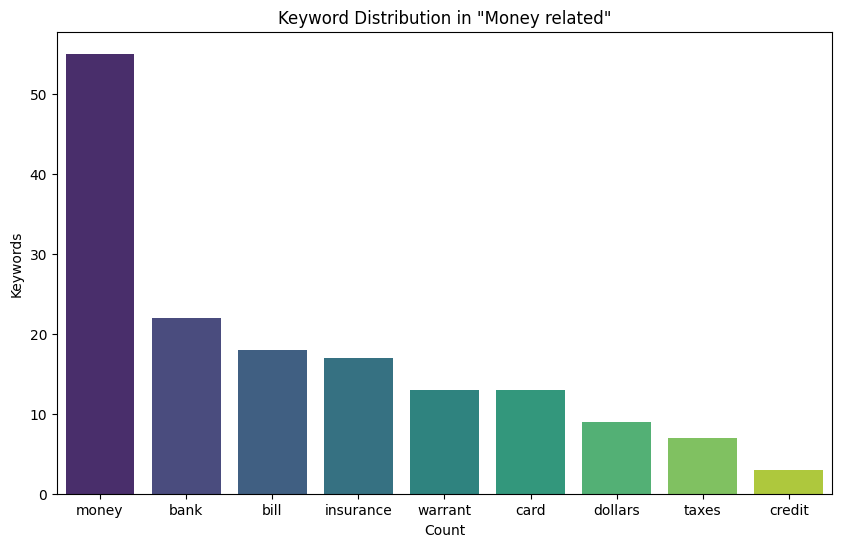

In [ ]:
# Count keywords in the original data including NaN values
original_keyword_counts = result["Money related"].value_counts(dropna=False)  # Includes NaN

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=original_keyword_counts.index, y=original_keyword_counts.values, palette="viridis")
plt.title('Keyword Distribution in "Money related"')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

# Export into csv

In [ ]:
result.to_csv("result.csv", index=False)